## RQ$_1$ and RQ$_{1.1}$

RQ$_1$: What is the distribution of genres among open-source indie games?

RQ$_{1.1}$: How do genres differ in terms of user ratings and rating volume?

In [ ]:
!pip install upsetplot

import pandas as pd
import matplotlib.pyplot as plt
import chardet
import re
import matplotlib as mpl

from upsetplot import UpSet, from_memberships
from prettytable import PrettyTable

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for upsetplot: filename=upsetplot-0.9.0-py3-none-any.whl size=24866 sha256=e7b21ed050f01ac0e1f8d70e6e8319df6dfa1faf2b8cd3c48cc0428932b413f1
  Stored in directory: /root/.cache/pip/wheels/5d/7a/54/1460364da0fe4e17c256b7a28191fa373d81292fcf73a4ddb8
Successfully built upsetplot


In [ ]:
# try to guess the right encoding
with open("data/Dataset_Final_GAS.csv", "rb") as f:
    dataset_enconding = chardet.detect(f.read(50000))

# then load the file using the detected encoding
indie_games_df = pd.read_csv("data/Dataset_Final_GAS.csv",
                             encoding=dataset_enconding['encoding'])

# replace '?' in the Genre column with 'Uncategorized'
indie_games_df['Genre'] = indie_games_df['Genre'].replace('?', 'Uncategorized')

In [ ]:
indie_games_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 491 entries, 0 to 490
Data columns (total 74 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   Id                                     491 non-null    int64  
 1   Name                                   491 non-null    object 
 2   Updated                                491 non-null    object 
 3   Status                                 491 non-null    object 
 4   Platforms                              491 non-null    object 
 5   Rating                                 202 non-null    float64
 6   Author                                 491 non-null    object 
 7   Genre                                  491 non-null    object 
 8   Made with                              491 non-null    object 
 9   Tags                                   491 non-null    object 
 10  Average session                        491 non-null    object 
 11  Inputs

In [ ]:

# these are NOT video game genres
non_genres = {
    "cellular-automata", "emergent", "evolution", "Experimental", "golang",
    "Open Source", "Procedural Generation", "Phaser", "PICO-8", "Pixel Art",
    "Blender", "Adobe Photoshop", "Unity", "Audacity"
}

# split multiple genres, remove extra spaces, and count occurrences
genre_counts = (
    indie_games_df["Genre"]
    .dropna()  # remove nan values
    .apply(lambda x: [g.strip() for g in str(x).replace(';', ',').replace('/', ',').split(',')])  # normalize delimiters
    .explode()  # make each genre a separate row
)

# remove non-genre terms
genre_counts = genre_counts[~genre_counts.isin(non_genres)]
# count remaining genres
genre_counts = genre_counts.value_counts()

# prettytable output
table = PrettyTable()
table.field_names = ["Genre", "Number of Games"]

for genre, count in genre_counts.items():
    table.add_row([genre, count])

print(table)

+---------------------+-----------------+
|        Genre        | Number of Games |
+---------------------+-----------------+
|        Puzzle       |       103       |
|        Action       |        97       |
|      Platformer     |        69       |
|    Uncategorized    |        56       |
|      Adventure      |        44       |
|       Shooter       |        38       |
|      Simulation     |        38       |
|       Strategy      |        27       |
| Interactive Fiction |        22       |
|     Role Playing    |        18       |
|       Survival      |        17       |
|     Educational     |        14       |
|        Racing       |        14       |
|     Visual Novel    |        14       |
|      Card Game      |        7        |
|       Fighting      |        6        |
|        Rhythm       |        5        |
|        Sports       |        4        |
|     Exploration     |        1        |
|       Fantasy       |        1        |
|       Medieval      |        1  

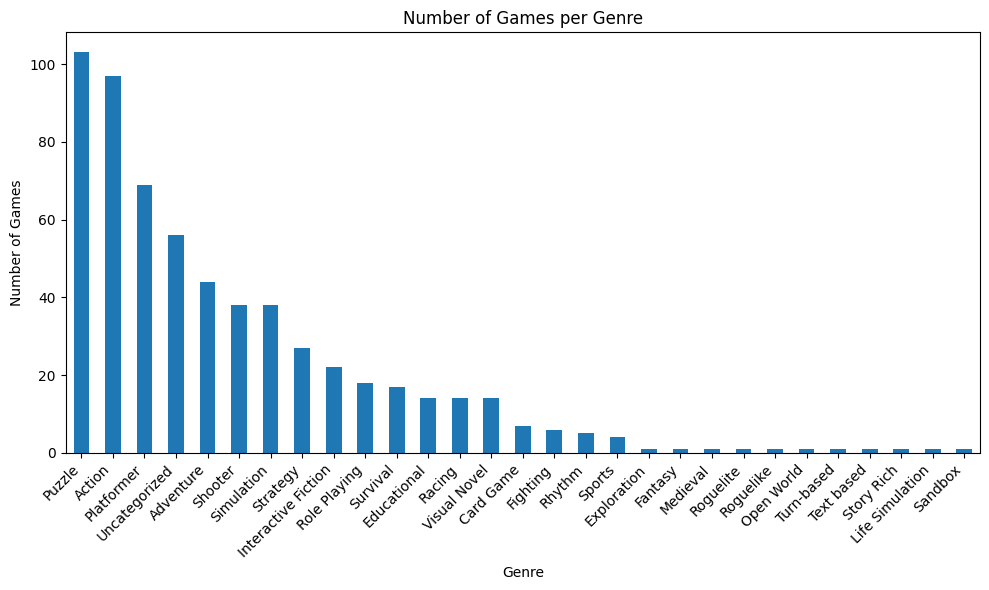

In [ ]:
# Create a bar plot
plt.figure(figsize=(10, 6))
genre_counts.plot(kind='bar')
plt.title("Number of Games per Genre")
plt.xlabel("Genre")
plt.ylabel("Number of Games")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

/usr/local/lib/python3.12/dist-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/usr/local/lib/python3.12/dist-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  styles["linewidth"].fillna(1, inplace=True)
/usr/local/lib/

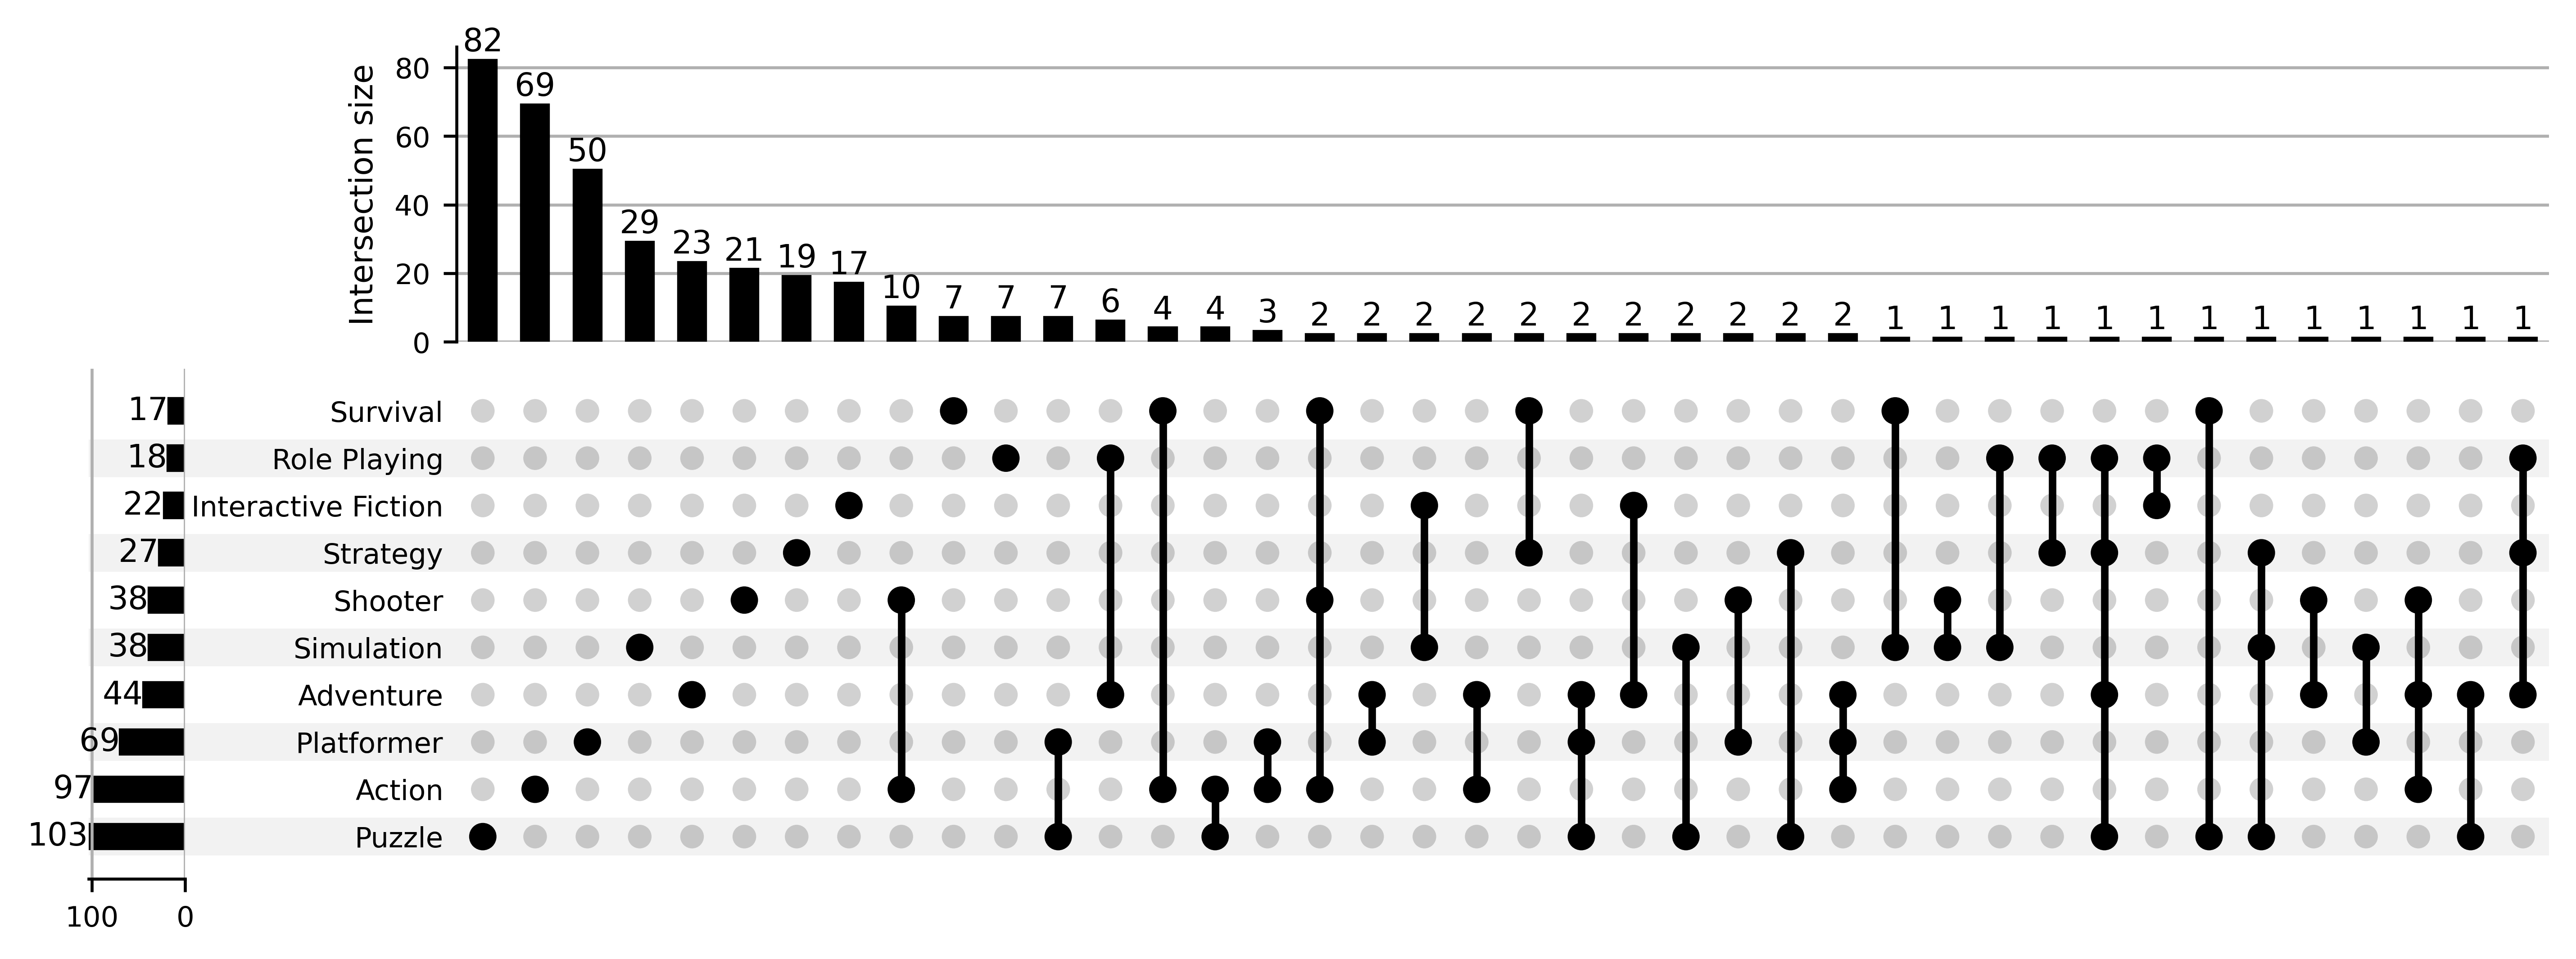

In [ ]:
# --- UpSet plot (top-10 genres, excluding 'Uncategorized')
# --------------------------
# Matplotlib style
# --------------------------
mpl.rcParams.update({
    "figure.dpi": 600,
    "savefig.dpi": 600,
    "font.family": "DejaVu Sans",
    "font.size": 8.5,
    "axes.labelsize": 8.5,
    "axes.titlesize": 9,
    "xtick.labelsize": 7.5,
    "ytick.labelsize": 7.5,
    "legend.fontsize": 7.5,
})
# IEEE two-column width approx. 3.35 in; adjust height to fit nicely
FIG_W, FIG_H = 3.35, 2.9

# --------------------------
# Load (again) + clean + tokenize
# --------------------------
df = pd.read_csv("data/Dataset_Final_GAS.csv")

def split_genres(val):
    if pd.isna(val):
        return []
    s = str(val).strip()
    if s in ["", "?", "Uncategorized"]:
        return []
    parts = re.split(r"[;,|/]", s)
    return [p.strip() for p in parts if p.strip() and p.strip() != "Uncategorized"]

df["Genre_list"] = df["Genre"].apply(split_genres)

# --------------------------
# Select top-10 most frequent genres
# --------------------------
all_genres = [g for genres in df["Genre_list"] for g in genres]
counts = pd.Series(all_genres).value_counts()
top10 = counts.head(10).index.tolist()

# memberships: only top-10 genres per game
memberships = []
for genres in df["Genre_list"]:
    g = [x for x in genres if x in top10]
    if g:
        memberships.append(g)

upset_data = from_memberships(memberships)

# --------------------------
# plot (UpSet)
# --------------------------
fig = plt.figure(figsize=(FIG_W, FIG_H))
up = UpSet(
    upset_data,
    subset_size="count",
    show_counts=True,          # numbers atop intersection bars
    sort_by="cardinality",     # largest intersections first
    sort_categories_by="cardinality",  # sort sets by size (left)
    element_size=18            # compact enough for two-column
)
up.plot(fig=fig)

# Optional: tighten whitespace; avoid suptitle
plt.tight_layout()

# --------------------------
# Save for paper inclusion
# --------------------------
plt.savefig("upset_top10_genres.pdf", bbox_inches="tight")
plt.show();

In [ ]:
# Load the dataset (again)
df = pd.read_csv("data/Dataset_Final_GAS.csv")

# Ensure the 'Rating' column is numeric
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

# Remove rows with missing or invalid ratings
df = df.dropna(subset=["Rating"])
df = df[df["Rating"] > 0]

# Clean and split genres
def split_genres(val):
    if pd.isna(val):
        return []
    s = str(val).strip()
    if s in ["", "?", "Uncategorized"]:
        return []
    # Split on commas, semicolons, slashes, or pipes
    parts = re.split(r"[;,|/]", s)
    return [p.strip() for p in parts if p.strip()]

df["Genre_list"] = df["Genre"].apply(split_genres)

print(f"Total games after cleaning: {len(df)}")
# print(f"Columns available: {list(df.columns)}")


Total games after cleaning: 202


In [ ]:
# --- Overall descriptive statistics for game ratings ---
overall_stats = {
    "count": df["Rating"].count(),
    "mean": df["Rating"].mean(),
    "median": df["Rating"].median(),
    "std": df["Rating"].std(),
    "min": df["Rating"].min(),
    "max": df["Rating"].max(),
}

overall_df = pd.DataFrame([overall_stats])
print("Overall descriptive statistics for game ratings:")
print(overall_df.round(2))

Overall descriptive statistics for game ratings:
   count  mean  median   std  min  max
0    202  4.54     4.7  0.59  1.9  5.0


## Expand multi-genre games

Each game that belongs to multiple genres will contribute one row per genre.
This ensures that every genre’s rating distribution reflects all games associated with it.

In [ ]:
# --- Expand multi-genre games ---------------------------------------
# Explode the Genre_list column so each genre gets its own row
df_exploded = df.explode("Genre_list").reset_index(drop=True)

# Remove any empty genres just in case
df_exploded = df_exploded[df_exploded["Genre_list"].notna()]
df_exploded = df_exploded[df_exploded["Genre_list"] != ""]

print(f"Expanded dataset size: {len(df_exploded)} rows (multi-genre games counted multiple times)")


Expanded dataset size: 242 rows (multi-genre games counted multiple times)


In [ ]:
# --- Compute descriptive stats by genre -----------------------------
genre_stats = (
    df_exploded.groupby("Genre_list")["Rating"]
    .agg(["count", "mean", "median", "std", "min", "max"])
    .sort_values(by="mean", ascending=False)
)

print("Average rating and dispersion by genre:")
print(genre_stats.round(2))


Average rating and dispersion by genre:
                     count  mean  median   std  min  max
Genre_list                                              
Sports                   2  5.00    5.00  0.00  5.0  5.0
Fighting                 2  4.75    4.75  0.35  4.5  5.0
Platformer              22  4.72    4.80  0.32  4.0  5.0
Visual Novel             9  4.67    4.70  0.32  4.0  5.0
Rhythm                   3  4.67    4.70  0.15  4.5  4.8
Adventure               19  4.61    4.80  0.51  3.0  5.0
Educational              7  4.60    4.70  0.45  4.0  5.0
Racing                   4  4.60    4.70  0.49  4.0  5.0
Shooter                 14  4.57    4.90  0.60  3.0  5.0
Action                  40  4.56    4.85  0.62  3.0  5.0
Interactive Fiction     16  4.55    4.70  0.49  3.0  4.9
Puzzle                  45  4.50    4.60  0.51  3.0  5.0
Role Playing            10  4.45    4.70  0.65  3.0  5.0
Simulation              26  4.41    4.55  0.69  2.5  5.0
Strategy                14  4.39    4.60  0.68  

<Figure size 6000x3600 with 0 Axes>

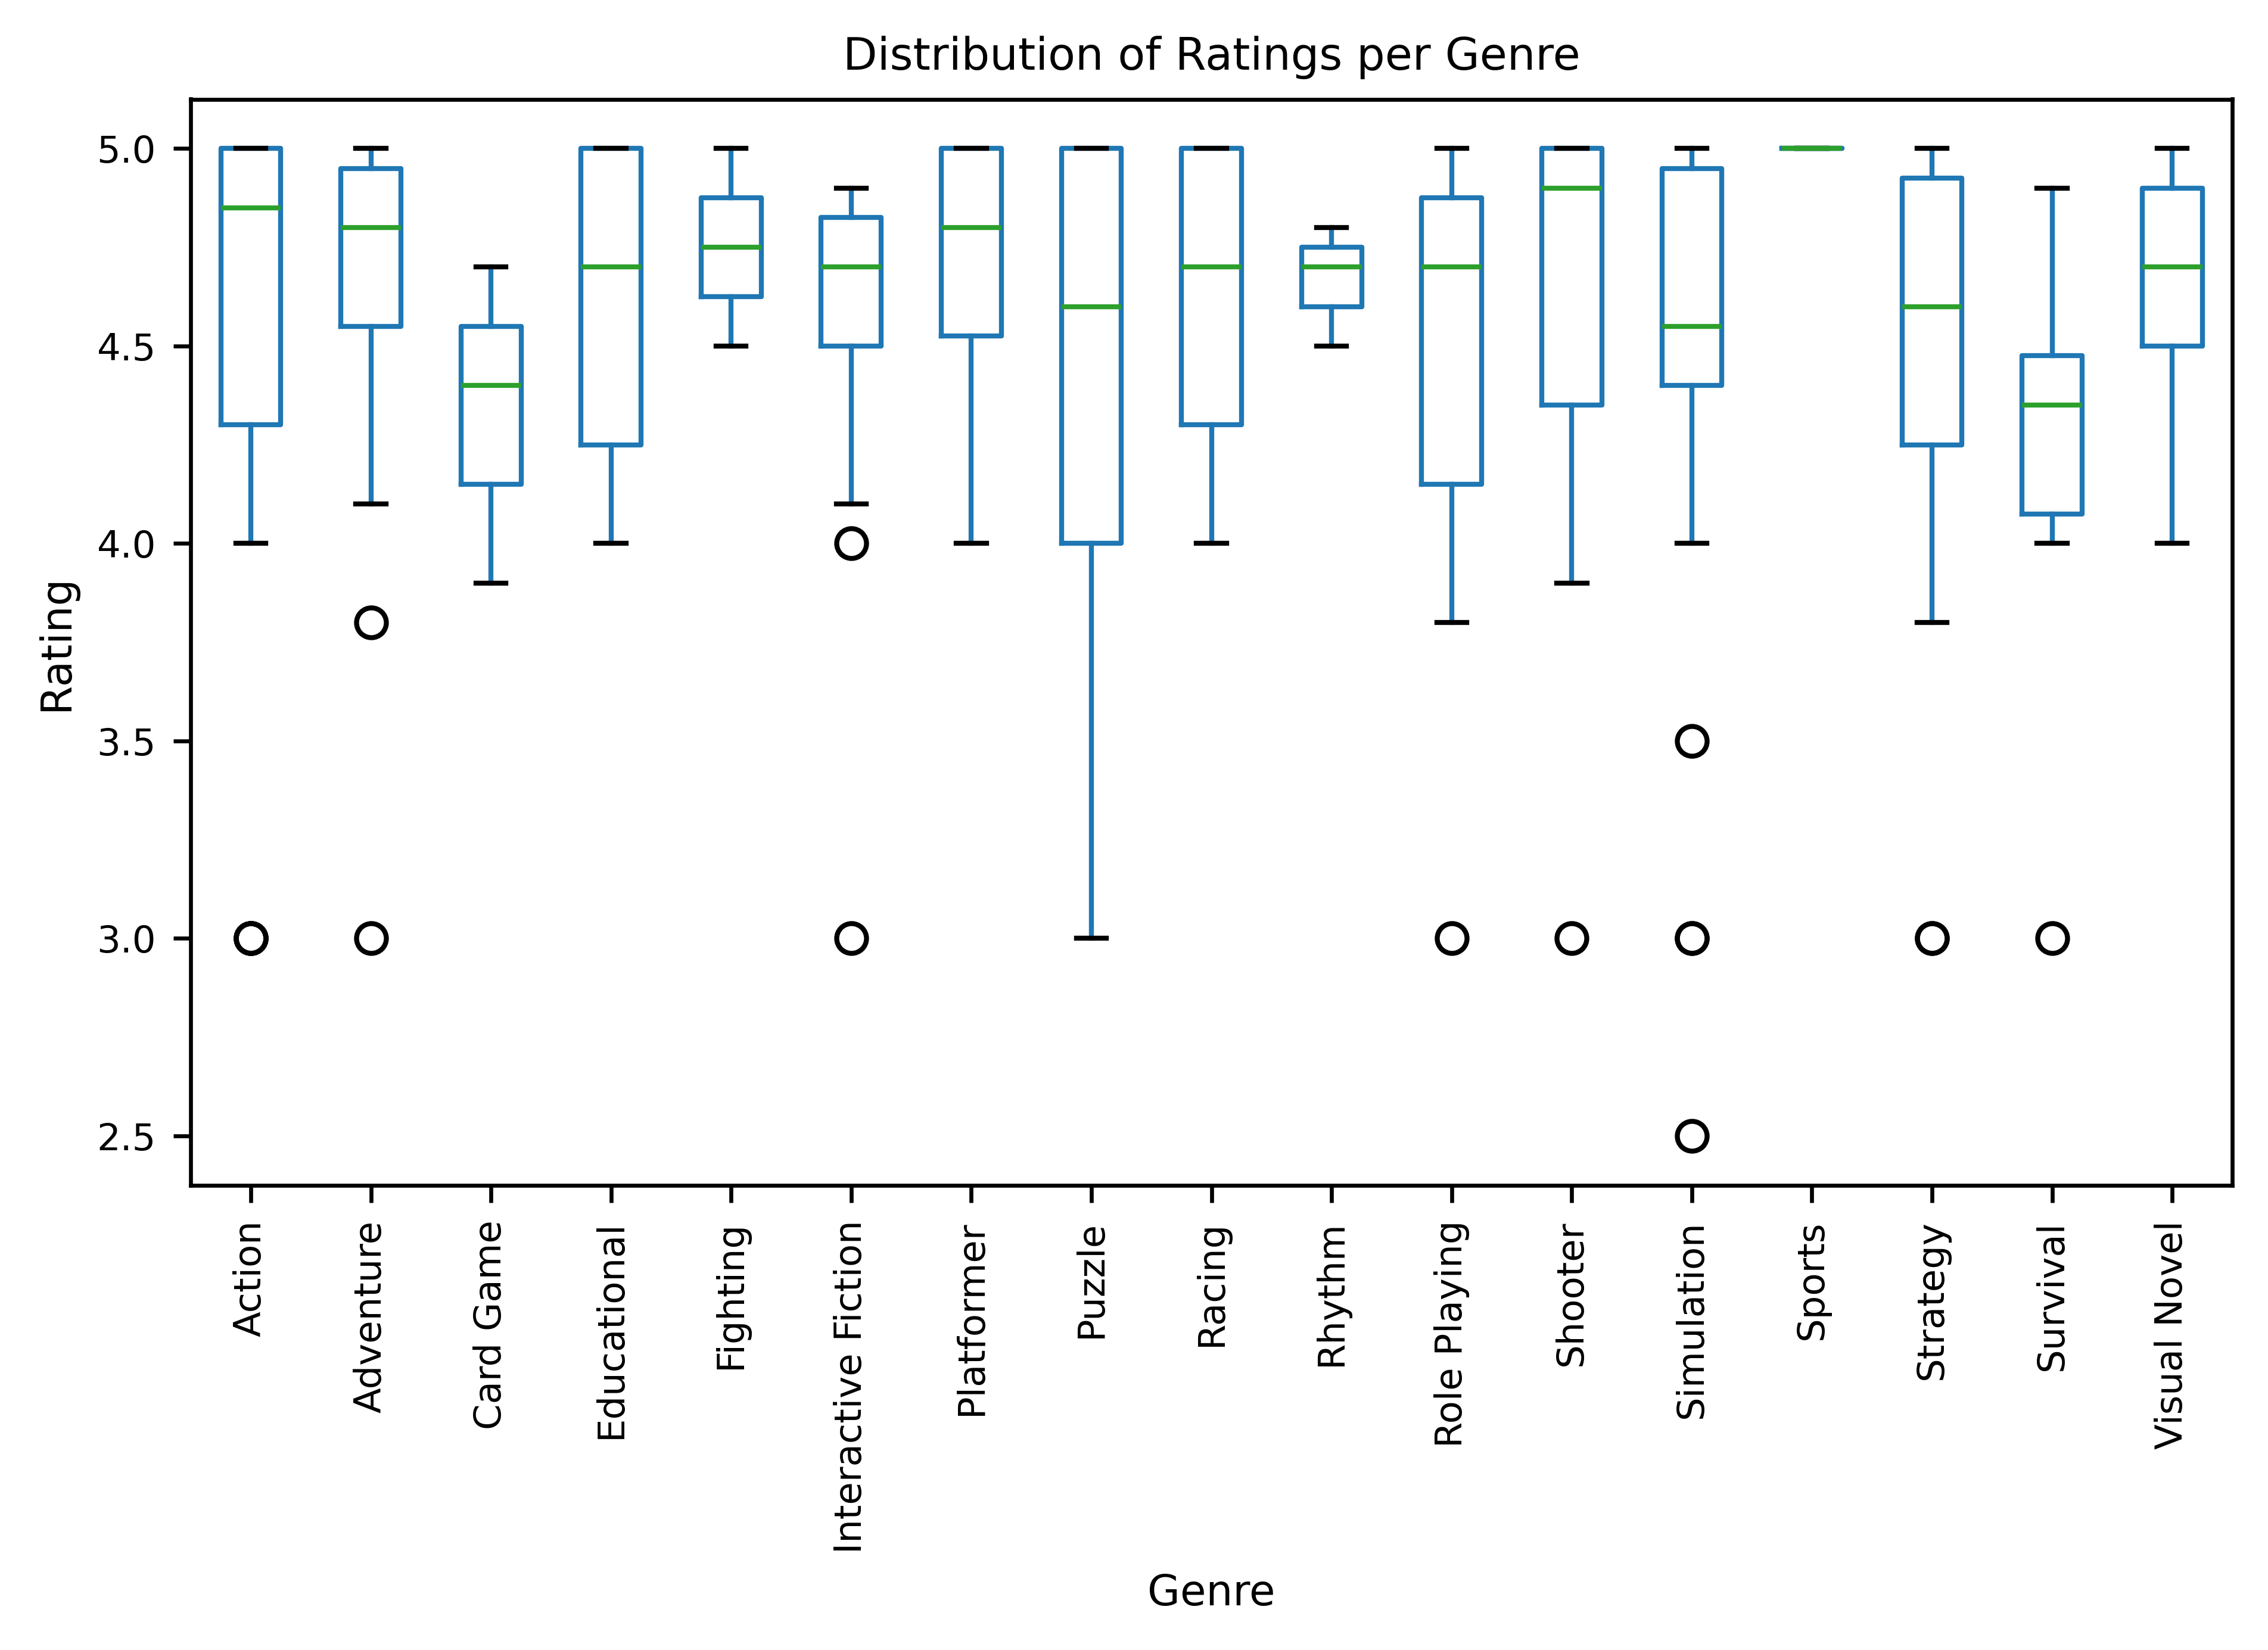

In [ ]:

plt.figure(figsize=(10, 6))
df_exploded.boxplot(column="Rating", by="Genre_list", grid=False, vert=True)
plt.xticks(rotation=90)
plt.xlabel("Genre")
plt.ylabel("Rating")
plt.title("Distribution of Ratings per Genre")
plt.suptitle("")  # Remove default pandas title
plt.tight_layout()
plt.show()


In [ ]:

# Load your dataset
df = pd.read_csv("data/Dataset_Final_GAS.csv")

# Convert Rating to numeric (invalid strings become NaN)
df["Rating"] = pd.to_numeric(df["Rating"], errors="coerce")

# Identify rows with missing or invalid ratings
invalid_ratings = df["Rating"].isna() | (df["Rating"] <= 0)

# Count and display results
num_invalid = invalid_ratings.sum()
total_games = len(df)
pct_invalid = (num_invalid / total_games) * 100

print(f"Number of games without a valid rating: {num_invalid}")
print(f"Total number of games: {total_games}")
print(f"Percentage of missing/invalid ratings: {pct_invalid:.2f}%")


Number of games without a valid rating: 289
Total number of games: 491
Percentage of missing/invalid ratings: 58.86%
